# Car Price Prediction
## Problem Statement
This project goal is to train a model that will suggest the price of the car.

In [1]:
#importing the libraries
import csv
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import lightgbm as lgb

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, plot_roc_curve
from sklearn.model_selection import train_test_split

## Step 1: Reading and understanding Data
1. Reading Data
2. Percentage of NaN values in each row


In [2]:
f = pd.read_csv("otomoto_price_prediction_data.csv")

print(f.isna().mean())

make               0.000000
model              0.000000
vehicle_year       0.000000
mileage            0.006566
engine_capacity    0.010562
engine_power       0.007657
gearbox            0.006620
fuel_type          0.000000
damaged            0.000000
is_business        0.000000
target_price       0.000000
dtype: float64


3. As the table contains very few **NaN** values the output of the problem won't be higly affect if we just delete the rows that contain those values

In [3]:
f=f.dropna()

## Step 2: Visualizing the Data
1. Car price distribution

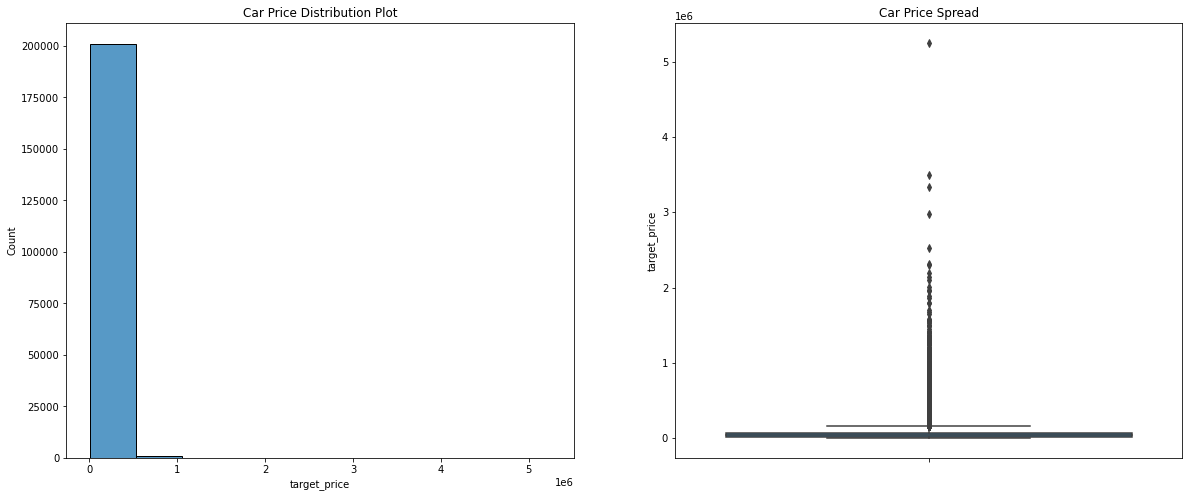

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.histplot(f.target_price,bins = 10)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=f.target_price)

plt.show()

In [5]:
f['target_price'].describe()

count    2.019710e+05
mean     6.137562e+04
std      8.333600e+04
min      6.000000e+02
25%      1.790000e+04
50%      3.590000e+04
75%      7.390000e+04
max      5.250000e+06
Name: target_price, dtype: float64

There is a high variance in the car prices. (75% of the prices are below 7,390zl, whereas the remaining 15% are between 7,390zl and 5.25Mzl).


2. Car brand distribution


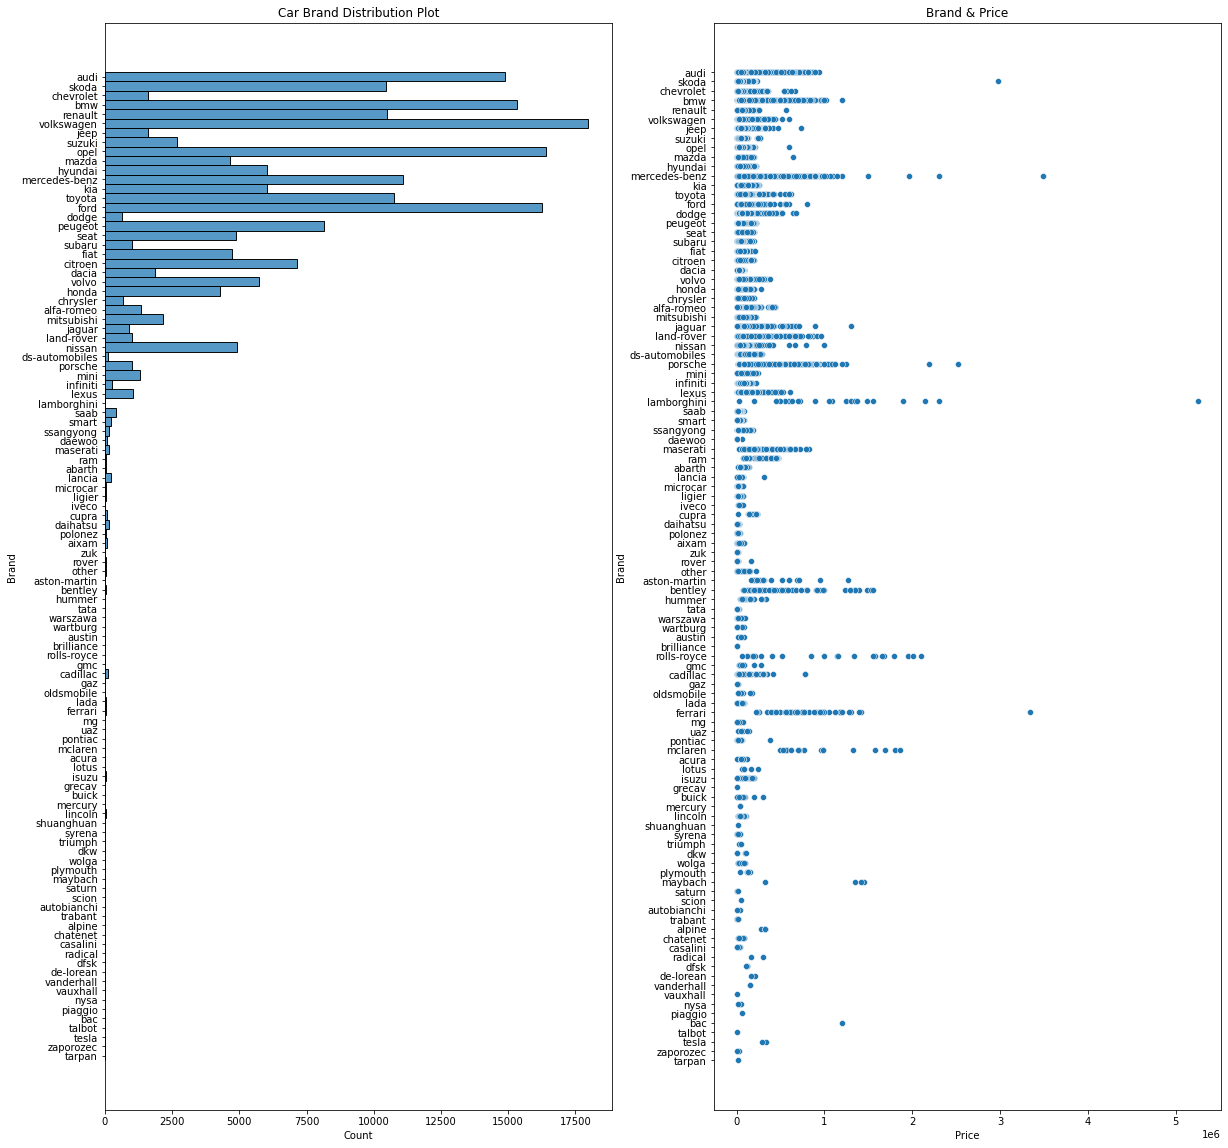

In [6]:

plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.title('Car Brand Distribution Plot')
plt.ylabel('Brand')
sns.histplot(y=f.make)
plt.subplot(1,2,2)
plt.title('Brand & Price')
sns.scatterplot(x=f['target_price'],y=f['make'])
plt.ylabel('Brand')
plt.xlabel('Price')
plt.show()

Car brands are strangely distributed with opel, audi, bmw, volkswagen and ford having around 15,000 sales and some other brands having only one.

Car prices are normally very close for each brand.
 
3. Car fuel distribution

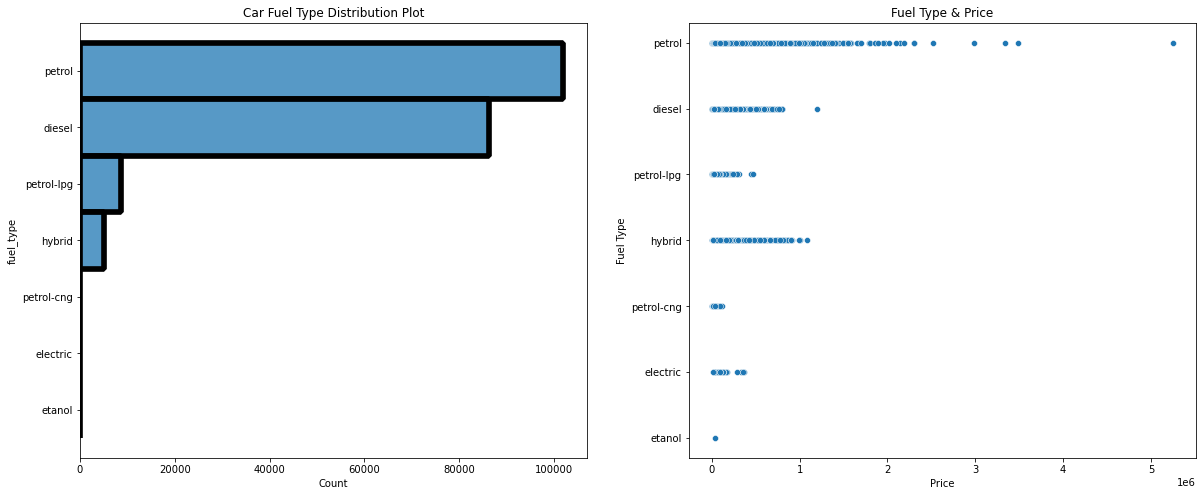

In [7]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.title('Car Fuel Type Distribution Plot')
sns.histplot(y=f.fuel_type)
plt.subplot(1,2,2)
plt.title('Fuel Type & Price')
sns.scatterplot(x=f['target_price'],y=f['fuel_type'])
plt.ylabel('Fuel Type')
plt.xlabel('Price')
plt.show()

The most common fuel type is petrol.

The prices of the car tend to vary a little bit for each fuel type.

4. Car engine distribution

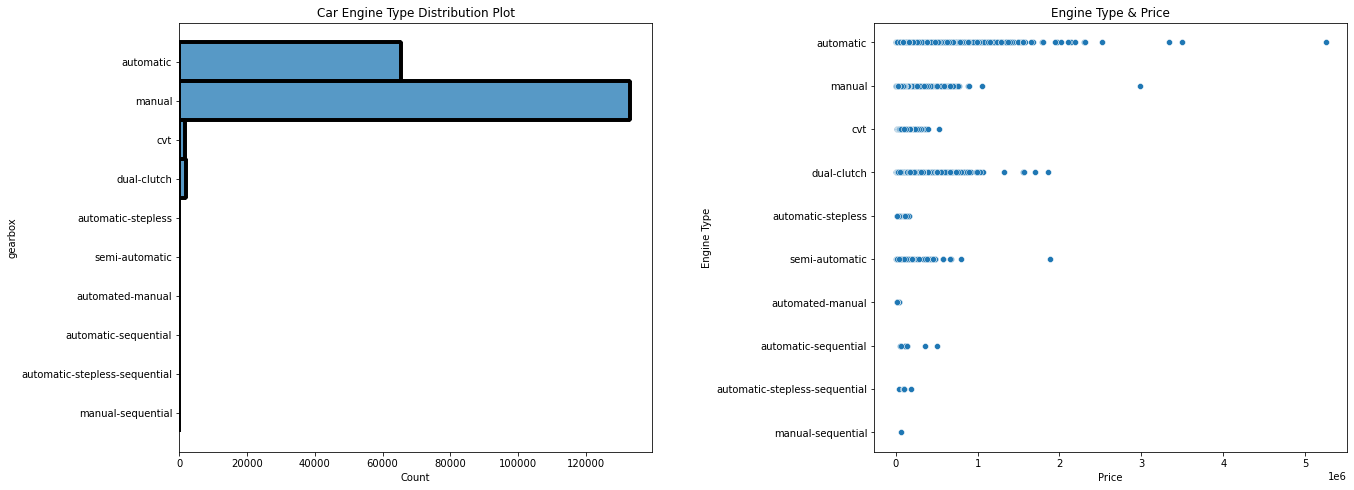

In [8]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.title('Car Engine Type Distribution Plot')
sns.histplot(y=f.gearbox)
plt.subplot(1,2,2)
plt.title('Engine Type & Price')
sns.scatterplot(x=f['target_price'],y=f['gearbox'])
plt.ylabel('Engine Type')
plt.xlabel('Price')
plt.tight_layout(pad=5)
plt.show()

The most common engine type in this dataset is manual.

The prices vary a bit fo each engine type.

5. Vehicle year distribution

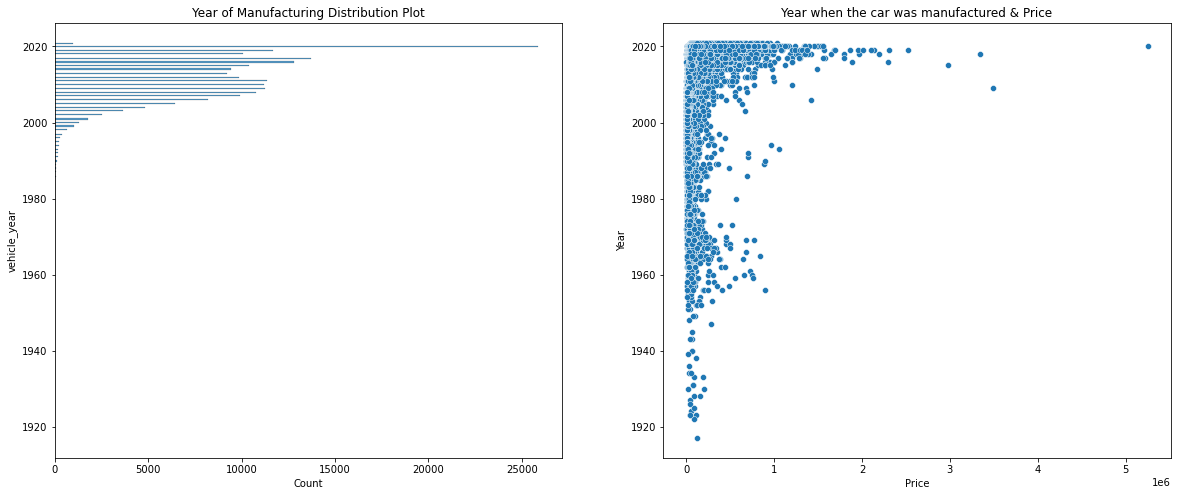

In [9]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.title('Year of Manufacturing Distribution Plot')
sns.histplot(y=f.vehicle_year)
plt.subplot(1,2,2)
plt.title('Year when the car was manufactured & Price')
sns.scatterplot(x=f['target_price'],y=f['vehicle_year'])
plt.ylabel('Year')
plt.xlabel('Price')
plt.show()

Most of the cars are from 2020 and almost all are from the last 20 years.

The prices tend to be a little bit higher for newer cars. But there are some cases where an older car can be more expensive.

6. Mileage distribution

count    2.019710e+05
mean     6.734712e+05
std      2.055277e+08
min      1.000000e+00
25%      4.596400e+04
50%      1.380000e+05
75%      1.990000e+05
max      9.060612e+10
Name: mileage, dtype: float64


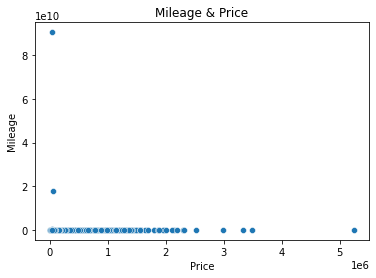

In [10]:
print(f['mileage'].describe())

plt.title('Mileage & Price')
sns.scatterplot(x=f['target_price'],y=f['mileage'])
plt.ylabel('Mileage')
plt.xlabel('Price')
plt.show()

75% of the cars have at least 46k Km and there are two cars that have a total mileage over 10 thousand millions Km.
These values are outliers.
7. Damaged cars distribution

count    201971.000000
mean          0.037892
std           0.190935
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: damaged, dtype: float64


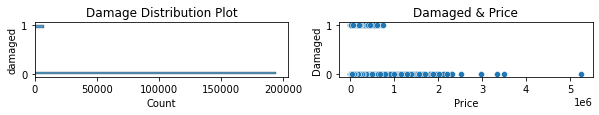

In [11]:
print(f['damaged'].describe())
plt.figure(figsize=(10, 1))
plt.subplot(1,2,1)
plt.title('Damage Distribution Plot')
sns.histplot(y=f.damaged)
plt.subplot(1,2,2)
plt.title('Damaged & Price')
sns.scatterplot(x=f['target_price'],y=f['damaged'])
plt.ylabel('Damaged')
plt.xlabel('Price')
plt.show()

There are around 3.8% damaged car in the dataset.
Damaged cars are normally cheaper.


count    201971.000000
mean          0.599626
std           0.489975
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: is_business, dtype: float64


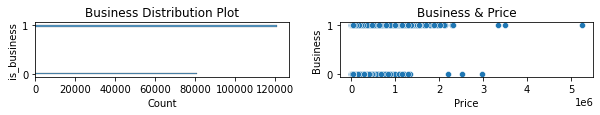

In [12]:
print(f['is_business'].describe())
plt.figure(figsize=(10, 1))
plt.subplot(1,2,1)
plt.title('Business Distribution Plot')
sns.histplot(y=f.is_business)
plt.subplot(1,2,2)
plt.title('Business & Price')
sns.scatterplot(x=f['target_price'],y=f['is_business'])
plt.ylabel('Business')
plt.xlabel('Price')
plt.show()

60% of the cars in the dataset are from a business.
Personal cars are normally cheaper.

## Step 3: Data Processing
1. Dummy variables

In [13]:
results = f['target_price']
data = f.drop(['target_price'], axis=1)

le_make = LabelEncoder()
le_model = LabelEncoder()
le_gearbox = LabelEncoder()
le_fuel_type= LabelEncoder()

data['make_n'] = le_make.fit_transform(data['make'])
data['model_n'] = le_model.fit_transform(data['model'])
data['gearbox_n'] = le_gearbox.fit_transform(data['gearbox'])
data['fuel_type_n'] = le_fuel_type.fit_transform(data['fuel_type'])

create a new table without the cars brand name, cars model, gearbox and fueltype


In [14]:
data_n = data.drop(['make','model','gearbox','fuel_type'], axis=1)


separate the tables (data_n, results) 
in the training stage
and int the testing stage

In [15]:
data_train,data_test,results_train,results_test = train_test_split(data_n,results,test_size=0.30,random_state=34)


### First Model (Gradient Boost)

In [16]:
lgb_model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    n_estimators=100,
    reg_lambda=1.0
)

lgb_model.fit(data_train,results_train)
lgb_results_pred = lgb_model.predict(data_test)

print('Coefficient of determination: %.2f'
      % r2_score(results_test, lgb_results_pred))

Coefficient of determination: 0.92


### Second Model (Descision Tree)

In [17]:
clf = tree.DecisionTreeRegressor()
clf.fit(data_train,results_train)

clf_results_pred = clf.predict(data_test)

print('Coefficient of determination: %.2f'
      % r2_score(results_test, clf_results_pred))

Coefficient of determination: 0.88


### Third Model (Random Forest)

In [18]:
forest = RandomForestRegressor(max_depth=50)
forest.fit(data_test,results_test)

forest_results_pred = forest.predict(data_test)

print('Coefficient of determination: %.2f'
      % r2_score(results_test, forest_results_pred))

Coefficient of determination: 0.99


The third model got the best score(0.99).
It takes significantly more time than the other models but the results are much more precise.